In [62]:
%load_ext autoreload
%autoreload 2
import seaborn as sns
import pinot
import torch
from matplotlib import pyplot as plt
import numpy as np
import scipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
ds = pinot.data.esol()

ds = pinot.data.utils.batch(ds, len(ds))

g_all, y_all = ds[0]


net = pinot.Net(
    representation=pinot.representation.Sequential(
        layer=pinot.representation.dgl_legacy.gn(),
        config=[32, 'tanh', 32, 'tanh', 32, 'tanh']),
        output_regressor=pinot.regressors.ExactGaussianProcessRegressor)

optimizer = torch.optim.Adam(net.parameters(), 1e-3)

acquisition = pinot.active.acquisition.probability_of_improvement

bo = pinot.active.experiment.BayesOptExperiment(
    net=net,
    acquisition=acquisition,
    optimizer=optimizer,
    strategy=
    data=ds[0],
    slice_fn=pinot.active.experiment._slice_fn_tuple, # pinot.active.
    collate_fn=pinot.active.experiment._collate_fn_graph, # pinot.active.
    n_epochs=10,
    )

In [64]:
xs = []
num_rounds = 40


idx = 0
bo.blind_pick(seed=None)
bo.update_data()

while idx < num_rounds:
    bo.train()
    bo.acquire()
    bo.update_data()
        
    
    x = pinot.active.acquisition.probability_of_improvement(
        pinot.metrics._independent(bo.net.condition(g_all)),
        y_best=bo.y_best).max().detach().numpy()
    
    xs.append(x)
    
    idx += 1



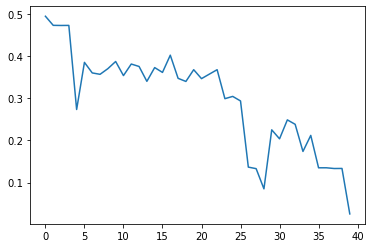

In [65]:
plt.plot(xs)